# **Zindi Mentorship Challenge3: Childline Kenya Call Volume Prediction Challenge by Zindi Mentorship Program**


This is a private hackathon for the July-August 2020 cohort of the Zindi mentor program.
The goal of this competition is to create a forecast model to predict the number of incoming calls that Childline Kenya will receive per hour per day.
The solution will help Childline manage its resources and staff their call center more efficiently, enabling them to better serve as many children as possible.
This competition is sponsored by Mtoto News and Childline Kenya.

In [ ]:
!pip install catboost

     |████████████████████████████████| 65.9MB 66kB/s 


In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from datetime import datetime
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

import lightgbm as lgb
from sklearn.ensemble import GradientBoostingRegressor


%matplotlib inline


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd drive/My\ Drive/third_comp/

[Errno 2] No such file or directory: 'drive/My Drive/third_comp/'
/content/drive/My Drive/third_comp


## **Data processing**

In [ ]:
df=pd.read_csv("train.csv")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (12,13,14,18) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
df.head(3)

,calldate,cc_status,maincat,subcat1,casepriority,referal,caller_gender,caller_age,caller_county,child_age,child_gender,child_county,parent_age,parent_gender,parent_county,Abuser_Relationship,Neglector_Relationship,Perpetrator_Relationship,Physical abuser_Relationship
0,2016-01-01 07:26:47,Closed,non-interventional,Blank call,Non Critical,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-01-01 07:32:30,Closed,non-interventional,Blank call,Non Critical,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-01-01 07:44:31,Closed,non-interventional,Blank call,Non Critical,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Convert the calldata to a datetime variable

In [ ]:
df.calldate=pd.to_datetime(df.calldate)

In [ ]:
df["calldate_"]=df["calldate"].apply(lambda x: datetime.strftime(x,"%Y%m%d%H%M%S"))


## we extract the variables year, month, hour minutes and second

In [ ]:
df["year"]=df["calldate"].apply(lambda x: datetime.strftime(x,"%Y"))
df["month"]=df["calldate"].apply(lambda x: datetime.strftime(x,"%m"))
df["day"]=df["calldate"].apply(lambda x: datetime.strftime(x,"%d"))
df["hour"]=df["calldate"].apply(lambda x: datetime.strftime(x,"%H"))
df["minute"]=df["calldate"].apply(lambda x: datetime.strftime(x,"%M"))
df["sec"]=df["calldate"].apply(lambda x: datetime.strftime(x,"%S"))

In [ ]:
df.drop(["calldate","calldate_","year","minute","sec"],axis=1,inplace=True)

##Create the variable number of call by grouping by month day and hour. This will give us the number of calls per month, day and hour.




In [ ]:
df["num_calls"]=1
data_set= (df.groupby(['month',"day", 'hour'])['num_calls'].sum().reset_index())

In [ ]:
data_set.head()

,month,day,hour,num_calls
0,01,01,07,8
1,01,01,08,41
2,01,01,09,20
3,01,01,10,34
4,01,01,11,44


### Here we try to make use the of the data KenyaPublicHolidays2016 and NairobiSchoolDates2016


We are adding this data because the number of call may have a strong correlation with hollydays

In [ ]:
df["num_calls"]=1
data= (df.groupby(['month',"day", 'hour'])['num_calls'].sum().reset_index())

In [ ]:
holy=pd.read_csv("KenyaPublicHolidays2016.csv")

In [ ]:
holy.head(5)

,Public holidays Kenya 2017,https://www.officeholidays.com/countries/kenya/2016.php,Unnamed: 2
0,NaN,NaN,NaN
1,Date,Holiday,NaN
2,2016/01/01,New Years Day,NaN
3,2016/03/25,Good Friday,NaN
4,2016/03/28,Easter Monday,NaN


In [ ]:
pub_holiday=pd.Series([])
for i in range(len(data)):
    if data["month"][i]=="01" and data["day"][i]=="01":
        pub_holiday[i]="holiday"
    elif data["month"][i]=="03" and data["day"][i]=="25":
        pub_holiday[i]="holiday"
    elif data["month"][i]=="03" and data["day"][i]=="28":
        pub_holiday[i]="holiday"
    elif data["month"][i]=="05" and data["day"][i]=="02":
        pub_holiday[i]="holiday"
    elif data["month"][i]=="06" and data["day"][i]=="01":
        pub_holiday[i]="holiday"
    elif data["month"][i]=="07" and data["day"][i]=="07":
        pub_holiday[i]="holiday"
    elif data["month"][i]=="09" and data["day"][i]=="11":
        pub_holiday[i]="holiday"
    elif data["month"][i]=="10" and data["day"][i]=="20":
        pub_holiday[i]="holiday"
    elif data["month"][i]=="12" and data["day"][i]=="12":
        pub_holiday[i]="holiday"
    elif data["month"][i]=="12" and data["day"][i]=="25":
        pub_holiday[i]="holiday"
    elif data["month"][i]=="12" and data["day"][i]=="26":
        pub_holiday[i]="holiday"
    elif data["month"][i]=="12" and data["day"][i]=="27":
        pub_holiday[i]="holiday"
    else :
        pub_holiday[i]="nopublicholiday"

data.insert(4,"pubHolidays",pub_holiday)
        
        
        

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


Same as holidays, the school date may have effect on the number of calls. So we add the data NairobiSchoolDates2016 in our initial dataset.

In [ ]:
school=pd.read_csv("NairobiSchoolDates2016.csv")

In [ ]:
school.head(3)

,Term,Opening,Closing,Unnamed: 3,Unnamed: 4,Unnamed: 5
0,1,2016-01-04,2016-04-08,NaN,NaN,*year/month/day
1,2,2016-05-02,2016-08-05,NaN,NaN,https://www.standardmedia.co.ke/article/200018...
2,3,2016-09-05,2016-11-18,NaN,NaN,NaN


In [ ]:
schdate=pd.Series([])
for i in range(len(data)):
    if data["month"][i]=="01" or data["month"][i]=="04":
        schdate[i]="schooltime"
    elif data["month"][i]=="03" and (data["day"][i]=="25"):
        schdate[i]="notschooltime"

    elif data["month"][i]=="03" and (data["day"][i]=="28"):
        schdate[i]="notschooltime"

    elif data["month"][i]=="05" or data["month"][i]=="08":
              schdate[i]="schooltime"
    elif data["month"][i]=="05" and (data["day"][i]=="02"):
        schdate[i]="notschooltime"
    
    elif data["month"][i]=="06" and data["day"][i]=="01" :
        schdate[i]="notschooltime"
    elif data["month"][i]=="07" and (data["day"][i]=="07"):
        schdate[i]="notschooltime"

    elif data["month"][i]=="09" or data["month"][i]=="11":
        schdate[i]="schooltime"
    elif data["month"][i]=="10" and data["day"][i]=="20":
        schdate[i]="notschooltime"
    elif data["month"][i]=="12" and data["day"][i]!="12":
        schdate[i]="notschooltime"
    elif data["month"][i]=="12" and data["day"][i]!="25":
        schdate[i]="notschooltime"
    elif data["month"][i]=="12" and data["day"][i]!="26":
        schdate[i]="notschooltime"
    elif data["month"][i]=="12" and data["day"][i]!="27":
        schdate[i]="notschooltime"

    else:
        schdate[i]="notschooltime"
data.insert(5,"schooltimes",schdate)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


In [ ]:
data["year"]="2016"

In [ ]:
data

,month,day,hour,num_calls,pubHolidays,schooltimes,year
0,01,01,07,8,holiday,schooltime,2016
1,01,01,08,41,holiday,schooltime,2016
2,01,01,09,20,holiday,schooltime,2016
3,01,01,10,34,holiday,schooltime,2016
4,01,01,11,44,holiday,schooltime,2016
...,...,...,...,...,...,...,...
3692,07,12,19,39,nopublicholiday,notschooltime,2016
3693,07,12,20,70,nopublicholiday,notschooltime,2016
3694,07,12,21,44,nopublicholiday,notschooltime,2016
3695,07,12,22,55,nopublicholiday,notschooltime,2016


In [ ]:
data['time_index'] = data[['year','month',"day","hour"]].apply(lambda x: '-'.join(x), axis=1)

In [ ]:
data.head()

,month,day,hour,num_calls,pubHolidays,schooltimes,year,time_index
0,01,01,07,8,holiday,schooltime,2016,2016-01-01-07
1,01,01,08,41,holiday,schooltime,2016,2016-01-01-08
2,01,01,09,20,holiday,schooltime,2016,2016-01-01-09
3,01,01,10,34,holiday,schooltime,2016,2016-01-01-10
4,01,01,11,44,holiday,schooltime,2016,2016-01-01-11


In [ ]:
data.to_csv("ts.csv",index=False)#this is the training dataset

## Generating the dates that we'll Forcast on its num_calls
We are suppose to predict the numbers of calls per hour from 13 of Jully to 6 of september 

In [ ]:
date_rng = pd.date_range(start='13/07/2016', end='16/09/2016', freq='H')

In [ ]:
df2 = pd.DataFrame(date_rng, columns=['date'])

In [ ]:
final_test=df2.iloc[0:1344]
final_test.shape

(1344, 1)

In [ ]:
final_test.date=pd.to_datetime(final_test.date)
final_test["year"]=final_test["date"].apply(lambda x: datetime.strftime(x,"%Y"))
final_test["month"]=final_test["date"].apply(lambda x: datetime.strftime(x,"%m"))
final_test["day"]=final_test["date"].apply(lambda x: datetime.strftime(x,"%d"))
final_test["hour"]=final_test["date"].apply(lambda x: datetime.strftime(x,"%H"))

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

In [ ]:

final_test.head(20)

,date,year,month,day,hour
0,2016-07-13 00:00:00,2016,07,13,00
1,2016-07-13 01:00:00,2016,07,13,01
2,2016-07-13 02:00:00,2016,07,13,02
3,2016-07-13 03:00:00,2016,07,13,03
4,2016-07-13 04:00:00,2016,07,13,04
5,2016-07-13 05:00:00,2016,07,13,05
6,2016-07-13 06:00:00,2016,07,13,06
7,2016-07-13 07:00:00,2016,07,13,07
8,2016-07-13 08:00:00,2016,07,13,08
9,2016-07-13 09:00:00,2016,07,13,09


### create the variables holyday and school time.
So here we consider all the holydays and school time that exist between 13 Jully and 6 september

In [ ]:

pub_holiday=pd.Series([])
for i in range(len(final_test)):
    if final_test["month"][i]=="07" and final_test["day"][i]=="07":
        pub_holiday[i]="holiday"
    else :
        pub_holiday[i]="nopublicholiday"

final_test.insert(4,"pubHolidays",pub_holiday)
        
        
        

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


In [ ]:
schdate=pd.Series([])
for i in range(len(final_test)):
    if data["month"][i]=="07" or data["month"][i]=="08":
              schdate[i]="schooltime"
    elif data["month"][i]=="09" and data["day"][i]=="05":
              schdate[i]="schooltime"
    else:
        schdate[i]="notschooltime"
final_test.insert(6,"schooltimes",schdate)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


In [ ]:
final_test['time_index'] = final_test[['year','month',"day","hour"]].apply(lambda x: ''.join(x), axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
final_test.head()

,date,year,month,day,pubHolidays,hour,schooltimes,time_index
0,2016-07-13 00:00:00,2016,07,13,nopublicholiday,00,notschooltime,2016071300
1,2016-07-13 01:00:00,2016,07,13,nopublicholiday,01,notschooltime,2016071301
2,2016-07-13 02:00:00,2016,07,13,nopublicholiday,02,notschooltime,2016071302
3,2016-07-13 03:00:00,2016,07,13,nopublicholiday,03,notschooltime,2016071303
4,2016-07-13 04:00:00,2016,07,13,nopublicholiday,04,notschooltime,2016071304


### Save our test data as a csv file.
Now that we have created our test data with the same variable than the train data, we save it as a csv file.

In [ ]:
final_test.to_csv("tsTest.csv",index=False)#this is the test dataset
testdataset=final_test["time_index"]#extracting the time_index from the test dataset
testdataset.to_csv("submission.csv",index=False)#holds the time_index column

In [ ]:
df=pd.read_csv("ts.csv",index_col=[7], parse_dates=[7])

In [ ]:
df.drop(['month', 'day', 'hour','schooltimes',
       'pubHolidays', 'year'],inplace=True,axis=1)

In [ ]:
df

,num_calls
time_index,
2016-01-01 07:00:00,8
2016-01-01 08:00:00,41
2016-01-01 09:00:00,20
2016-01-01 10:00:00,34
2016-01-01 11:00:00,44
...,...
2016-07-12 19:00:00,39
2016-07-12 20:00:00,70
2016-07-12 21:00:00,44


Here we observe that there not stationarity, so we try to do some transformation to make our test set stationary.

# Splitting And Visualizing Our Data

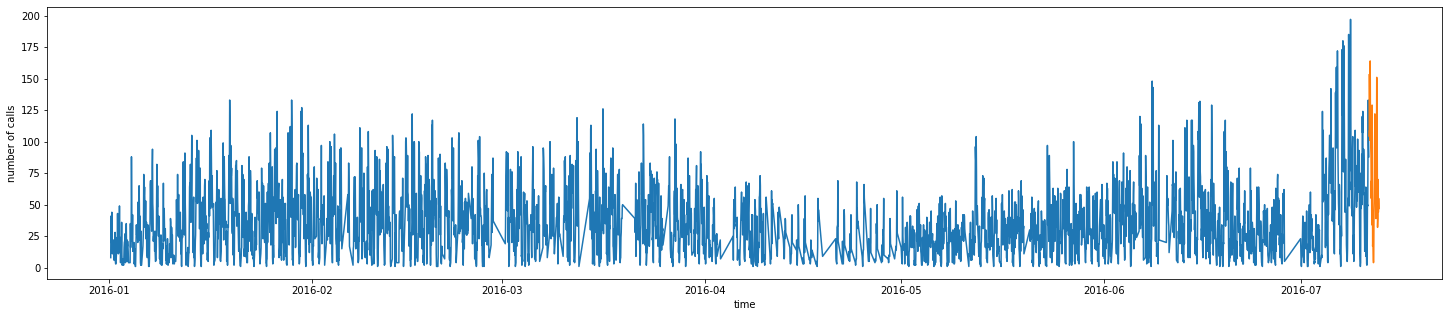

In [ ]:
train=df[0:3660]
test=df[3660:3699]
plt.figure(figsize=(25,5))
plt.xlabel('time')
plt.ylabel('number of calls')
plt.plot(train.index,train)
plt.plot(test.index,test)
plt.show(block=False)



# Creating Features for our test set

In [ ]:
def create_ts_features(df):
 
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofweek'] = df['date'].dt.dayofweek
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    X = df[['hour','dayofweek','dayofyear','dayofmonth','weekofyear']]
    return X

### split the data in train and validation

In [ ]:
X_train, y_train = create_ts_features(train), train['num_calls']
X_test, y_test   = create_ts_features(test), test['num_calls']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

### parameters turning using grid search

Here we do some parameters turning for xgboost


In [ ]:
xgb1 = xgb.XGBRegressor()
parameters = {'nthread':[2,4,5], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.11,.03, 0.05, 0.07], #so called `eta` value
              'max_depth': [5, 6, 7,8],
              'min_child_weight': [5,4,3],
              'silent': [1],
              'subsample': [0.7,.74,.8],
              'colsample_bytree': [0.6,0.7, 0.8],
              'n_estimators': [200, 400,600,1000],
              'gamma':[0.5,0.7,0.8]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 5,
                        n_jobs = 3,
                        verbose=True)

xgb_grid.fit(X_train,y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

### parameters turning for Random forest


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(2, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.1min
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 11.7min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed: 25.9min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 33.8min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [ ]:
rf_random.best_params_

{'bootstrap': True,
 'max_depth': 12,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1000}

# Training XGBoost

In [ ]:
params={'colsample_bytree': 0.8, 
        'gamma': 0, 'learning_rate': 0.05, 
        'max_depth': 6, 'min_child_weight': 2, 
        'n_estimators': 400, 'nthread': 4, 
        'objective': 'reg:linear',
        'silent': 1,
        'subsample': 0.74}
xgb_model = xgb.XGBRegressor(**params)
xgb_model.fit(X_train,y_train,eval_set=[(X_train, y_train), (X_test, y_test)],early_stopping_rounds=50,  verbose=False)     

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=6, min_child_weight=2, missing=None, n_estimators=400,
             n_jobs=1, nthread=4, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, silent=1,
             subsample=0.74, verbosity=1)

# Training random forest

In [ ]:
params_rf={'bootstrap': True,
 'max_depth': 12,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1000}
randf=RandomForestRegressor(**params_rf)
randf.fit(X_train,y_train)     

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=12, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

# Training light GBM

In [ ]:
hyper_param= {'n_estimators': [200,500,1000, 1500],
               'max_depth':  [4, 5, 8, 15],
               'num_leaves': [5,10,15, 31],
               'subsample': [0.6, 0.7, 0.8, 1.0],
               'colsample_bytree': [0.6, 0.7, 0.8, 1.0],
              'learning_rate':[0.05,0.07,0.1,0.2],
              'boosting':['gbdt','rf','dart','goss'],
              'random_state':[42,52,2018]
              }

lgb_saerch = lgb.LGBMRegressor(n_jobs=-1)


gs = GridSearchCV(lgb_saerch , hyper_param, scoring='r2', cv=5, verbose=1)
gs_results = gs.fit(X_train, y_train)
print("BEST PARAMETERS: " + str(gs_results.best_params_))
#print("BEST CV SCORE: " + str(gs_results.best_score_))

Fitting 5 folds for each of 49152 candidates, totalling 245760 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
lightgbm.basic.LightGBMError: Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /__w/1/s/python-package/compile/src/boosting/rf.hpp, line 28 .


  FitFailedWarning)


In [ ]:
params={'colsample_bytree': 0.8, 
        'learning_rate': 0.07, 
        'max_depth': 4, 
        'n_estimators': 600, 
        'num_leaves': 15,
        'subsample': 0.6
        }
lgb_model = lgb.LGBMRegressor(**params)
lgb_model.fit(X_train,y_train)


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
              importance_type='split', learning_rate=0.07, max_depth=4,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=600, n_jobs=-1, num_leaves=15, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=0.6, subsample_for_bin=200000, subsample_freq=0)

### training Catboost regressor

In [ ]:
clf = CatBoostRegressor()
params = {'iterations': [400,500, 600,1000],
          'depth': [4, 5, 6],
          'loss_function': ['RMSE'],
          'l2_leaf_reg': np.logspace(-20, -19, 3),
          'leaf_estimation_iterations': [5,10, 30,50,70],
          'learning_rate': [0.07,0.05,0.1,0.5,.7],
          'logging_level':['Silent'],
          'random_seed': [42]
         }
clf_grid = GridSearchCV(estimator=clf, param_grid=params, cv=5)
clf_grid.fit(X_train, y_train)

In [ ]:
clf_grid.best_params_

{'depth': 4,
 'iterations': 400,
 'l2_leaf_reg': 1e-20,
 'leaf_estimation_iterations': 5,
 'learning_rate': 0.05,
 'logging_level': 'Silent',
 'loss_function': 'RMSE',
 'random_seed': 42}

In [ ]:

params={'depth': 4,
 'iterations': 600,
 'l2_leaf_reg': 1e-2,
 'leaf_estimation_iterations': 5,
 'learning_rate': 0.07,
 'logging_level': 'Silent',
 'loss_function': 'RMSE',
 'random_seed': 42}

model=CatBoostRegressor(**params)
model.fit(X_train, y_train,eval_set=(X_test, y_test),plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

### Training Gradient Boosting 

In [ ]:
hyper_param= {'n_estimators': [1000, 1500, 2000, 2500],
               'max_depth':  [4, 5, 8, -1],
               'min_samples_split': [4,5,6],
              'learning_rate':[0.05,0.07,0.1,0.2]
               }
gbt_saerch = GradientBoostingRegressor()


gs = GridSearchCV(gbt_saerch , hyper_param, scoring='r2', cv=5, verbose=1)
gs_results = gs.fit(X_train, y_train)


In [ ]:
print("BEST PARAMETERS: " + str(gs_results.best_params_))


In [ ]:
params = {'learning_rate': 0.05, 'max_depth': 4, 'min_samples_split': 6, 'n_estimators': 1000}

reg = GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.05, loss='ls', max_depth=4,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=6,
                          min_weight_fraction_leaf=0.0, n_estimators=1000,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

# Forcasting
This visualization shows how our model fit the data. It will give us how closer our prediction is to the real values

In [ ]:

def ploting_performance(base_data, date_from, date_to, title=None):
    plt.figure(figsize=(15,3))
    if title == None:
        plt.title('From {0} To {1}'.format(date_from, date_to))
    else:
        plt.title(title)
    plt.xlabel('time monthdayhour')
    plt.ylabel('Number of calls')
    plt.plot(df.index,df, label='Oroginal')
    plt.plot(X_test.index,X_test_pred, label='Prediction')
    plt.legend()
    plt.xlim(left=date_from, right=date_to)


### Ensembling catboost, xgboost and light gbm
 Our model here is an ensembling of XGBoost and lightg
 bm





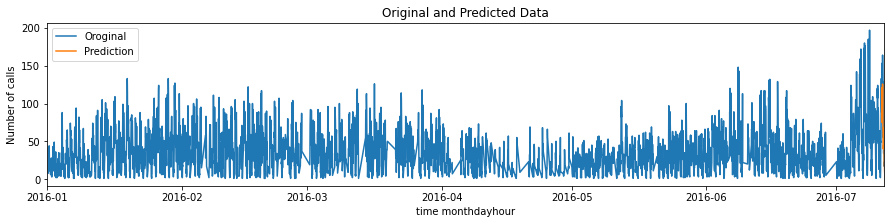

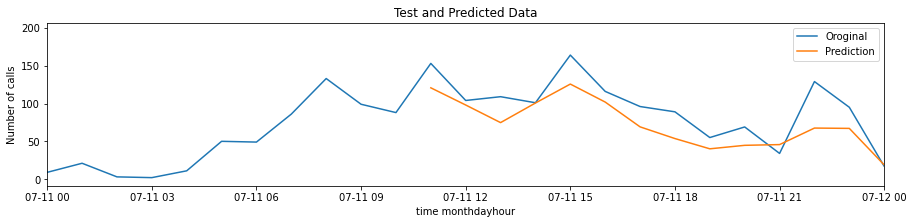

In [ ]:

X_test_pred = (lgb_model.predict(X_test)+xgb_model.predict(X_test))/2
    
ploting_performance(df,df.index[0].date(),df.index[-1].date(),
                 'Original and Predicted Data')

ploting_performance(y_test, y_test.index[0].date(), y_test.index[-1].date(),
                 'Test and Predicted Data')


# Performance Evaluation

In [ ]:
mean_squared_error(y_true=y_test,
                   y_pred=X_test_pred)

605.5041423801343

In [ ]:
mean_absolute_error(y_true=y_test,
                   y_pred=X_test_pred)

18.7954850729024

In [ ]:

def mean_absolute_percentage_error(y_true, y_pred): 
    #Calculates MAPE given y_true and y_pred
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [ ]:

X_test['num_calls'] = y_test
X_test['num_Prediction'] = X_test_pred
X_test['error'] = y_test - X_test_pred
X_test['abs_error'] = X_test['error'].apply(np.abs)
error_by_day = X_test.groupby(['dayofweek','hour']) \
   .mean()[['num_calls','num_Prediction','error','abs_error']]

error_by_day.sort_values('error', ascending=True).head(5)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


num_calls  num_Prediction      error  abs_error
dayofweek hour                                                 
1         12           39       97.621835 -58.621835  58.621835
          9            64       99.742414 -35.742414  35.742414
          10           72      104.900875 -32.900875  32.900875
          18           32       54.404216 -22.404216  22.404216
          11          108      123.208984 -15.208984  15.208984

## Have A Look At Afew Best Predicted Hours From TestSet

In [ ]:
error_by_day.sort_values('abs_error', ascending=True).head(5)

num_calls  num_Prediction     error  abs_error
dayofweek hour                                                
0         14          101      101.737072 -0.737072   0.737072
1         19           39       37.764280  1.235720   1.235720
          0            17       18.821402 -1.821402   1.821402
          3             4        6.019605 -2.019605   2.019605
          22           55       57.051871 -2.051871   2.051871

## Working With TestDataset For Submission

In [ ]:
test=pd.read_csv("tsTest.csv",index_col=[0], parse_dates=[0])

In [ ]:
test.drop(['month', 'day', 'hour', 'schooltimes',
       'pubHolidays', 'year',"time_index"],inplace=True,axis=1)

In [ ]:
test=create_ts_features(test)

In [ ]:
print(test.shape)
predictions = (lgb_model.predict(test)+xgb_model.predict(test))/2

(1344, 5)


# SubmissionFile Preparation

In [ ]:
appending=pd.read_csv("submission.csv")
appending["time_index"]

0       2016071300
1       2016071301
2       2016071302
3       2016071303
4       2016071304
           ...    
1339    2016090619
1340    2016090620
1341    2016090621
1342    2016090622
1343    2016090623
Name: time_index, Length: 1344, dtype: int64

In [ ]:
f=appending.iloc[0:]
f.values[0]

array([2016071300])

In [ ]:
submission = pd.DataFrame()
submission['time_index'] = appending["time_index"]
submission["calls"] = predictions.reshape((predictions.shape[0]))
submission.to_csv('lgbm.csv', index=False)

In [ ]:
df3=pd.read_csv('lgbm.csv')
cols = ['calls']
for col in cols:
   df3[col] = df3[col].apply(lambda x: int(x) if x == x else "")

In [ ]:
df_reorder = df3[["time_index","calls"]] # rearrange column here
df_reorder.to_csv('all22_en.csv', index=False)